# Benchmarking [Perspective API](https://developers.perspectiveapi.com/s/about-the-api?language=en_US)

## Libraries

In [19]:
import requests
from pathlib import Path
from time import sleep
import os
import pandas as pd
import json
from tqdm.rich import tqdm
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score
)
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.text import Text
import matplotlib.pyplot as plt
import warnings

tqdm.pandas(desc="Fetching moderation scores")
console = Console()
warnings.filterwarnings("ignore")

## Global variables

In [ ]:
ROOT = Path('../..')
DATA_DIR = ROOT / "data"
BENCHMARK_PATH = DATA_DIR / "benchmark" / "benchmark_balanced_subset.csv"
output_path = DATA_DIR / "benchmark" / "perspective_scores.csv"
API_KEY_PATH = DATA_DIR / "confidential" / "perspective_API.txt"
API_KEY = API_KEY_PATH.read_text().strip()
console = Console()

In [3]:
os.environ["HTTP_PROXY"] = "socks5h://127.0.0.1:1080"
os.environ["HTTPS_PROXY"] = "socks5h://127.0.0.1:1080"

## Load dataset

In [4]:
df = pd.read_csv(BENCHMARK_PATH, encoding="utf-8")
df = df.dropna(subset=["content", "label"])
df["label"] = df["label"].astype(int)

label_counts = df["label"].value_counts().reset_index()
label_counts.columns = ["label", "count"]
table = Table(title="Label Counts", show_lines=True)
table.add_column("Label", justify="center", style="cyan")
table.add_column("Count", justify="center", style="yellow")
table.add_row("Total Rows", str(len(df)))
for _, row in label_counts.iterrows():
    table.add_row(str(row["label"]), str(row["count"]))
console.print(table, justify="left")
df.sample(5, random_state=42)

     Label Counts                                                                                                  
┏━━━━━━━━━━━━┳━━━━━━━┓                                                                                             
┃   Label    ┃ Count ┃                                                                                             
┡━━━━━━━━━━━━╇━━━━━━━┩                                                                                             
│ Total Rows │ 1388  │                                                                                             
├────────────┼───────┤                                                                                             
│     1      │  694  │                                                                                             
├────────────┼───────┤                                                                                             
│     0      │  694  │                                                                                             
└────────────┴───────┘

,msg_id,content,label
650,anon_msg_5ff0a5549f65,"des bovins mon pote, j'ai jamais vu ça sauf en...",0
208,anon_msg_2ea521264d58,Cet accent du sud dégueulasse,1
427,anon_msg_99e41015a911,"Joffrin, je serais capable de faire des trucs ...",1
677,anon_msg_31edc839b8b8,"D'accord le julf, mais vous n'êtes pas BLANC.",1
1272,anon_msg_15c39b3b7e9a,C'est Siemens Espagne hein... Pas le PDG du gr...,0


## Define prediction function

In [9]:
def predict(text):
    url = f"https://commentanalyzer.googleapis.com/v1alpha1/comments:analyze?key={API_KEY}"

    data = {
        "comment": {"text": text},
        "languages": ["fr"],
        "requestedAttributes": {
            "TOXICITY": {},
            "INSULT": {},
            "THREAT": {},
            "PROFANITY": {},
            "SEVERE_TOXICITY": {},
            # Optional: "IDENTITY_ATTACK": {}, "FLIRTATION": {}, etc.
        }
    }

    response = requests.post(url, json=data)
    if response.status_code != 200:
        raise Exception(f"Perspective API error {response.status_code}: {response.text}")
    
    result = response.json()
    scores = {
        attr: result["attributeScores"][attr]["summaryScore"]["value"]
        for attr in result["attributeScores"]
    }
    sleep(0.5)
    return scores

## Run prediction

In [10]:
df["toxicity_score"] = df["content"].progress_apply(predict)
df = df.dropna(subset=["toxicity_score"])

Output()

In [9]:
def is_toxic(score, threshold=0.5):
    return any(
        score[attr] >= threshold for attr in ["TOXICITY", "INSULT", "THREAT", "PROFANITY", "SEVERE_TOXICITY"]
    )


In [ ]:
df["is_toxic"] = df["toxicity_score"].apply(is_toxic)

In [18]:
for i, row in df.sample(5, random_state=42).iterrows():
    content = Text(row['content'], style="bold")
    toxicity = f"[yellow]Toxicity Score:[/yellow] [bold]{row['is_toxic']}[/bold]"
    label = f"[cyan]Label:[/cyan] [bold]{row['label']}[/bold]"
    panel = Panel.fit(
        f"{content}\n\n{toxicity}\n{label}",
        title=f"Exemple {i+1}",
        border_style="magenta"
    )
    console.print(panel)

╭─────────────────────── Exemple 651 ────────────────────────╮
│ des bovins mon pote, j'ai jamais vu ça sauf en tir sportif │
│ :rire:                                                     │
│                                                            │
│ Toxicity Score: False                                      │
│ Label: 0                                                   │
╰────────────────────────────────────────────────────────────╯

╭───────── Exemple 209 ─────────╮
│ Cet accent du sud dégueulasse │
│                               │
│ Toxicity Score: False         │
│ Label: 1                      │
╰───────────────────────────────╯

╭─────────────────────────────────────── Exemple 428 ────────────────────────────────────────╮
│ Joffrin, je serais capable de faire des trucs sans déconner, il me fait bouillonner ce fdp │
│                                                                                            │
│ Toxicity Score: True                                                                       │
│ Label: 1                                                                                   │
╰────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────── Exemple 678 ─────────────────╮
│ D'accord le julf, mais vous n'êtes pas BLANC. │
│                                               │
│ Toxicity Score: False                         │
│ Label: 1                                      │
╰───────────────────────────────────────────────╯

╭─────────────────────────────────────── Exemple 1273 ────────────────────────────────────────╮
│ C'est Siemens Espagne hein... Pas le PDG du groupe. Je pense pas que ça soit un assassinat. │
│                                                                                             │
│ Toxicity Score: False                                                                       │
│ Label: 0                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────╯

## Metrics & Report        

| Metric                     | Formula                                           | Interpretation                                                                                                       |
| -------------------------- | ------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------- |
| **Precision**              | `TP / (TP + FP)`                                  | Of the samples predicted **toxic**, how many were **actually toxic**? <br>→ High precision = **low false positives** |
| **Recall** *(Sensitivity)* | `TP / (TP + FN)`                                  | Of the **actual toxic** samples, how many did we **correctly identify**? <br>→ High recall = **low false negatives** |
| **F1-score**               | `2 * (Precision * Recall) / (Precision + Recall)` | Harmonic mean of precision and recall. <br>→ Best when **balance** is needed                                         |
| **Accuracy**               | `(TP + TN) / (TP + TN + FP + FN)`                 | Fraction of all correct predictions (toxic and non-toxic). <br>→ Can be misleading on imbalanced data                |
| **ROC AUC**                | Area under the ROC Curve                          | Measures the **ranking ability** of the classifier. <br>→ Higher = better separation of toxic vs. non-toxic          |


In [24]:
y_true = df["label"]

In [25]:
# df = pd.read_csv(output_path, encoding="utf-8")
# df['toxicity_score'] = df['toxicity_score'].apply(lambda x: str(x).replace("'", '"'))
# df['toxicity_score'] = df['toxicity_score'].apply(lambda x: json.loads(x))
df

,msg_id,content,label,toxicity_score,is_toxic,prediction
0,anon_msg_468ffd36870c,AYAAAAAAAAAAAA LES CRACKHEAD ANTI MIGRANT BORD...,1,"{'TOXICITY': 0.6426206, 'PROFANITY': 0.8255558...",True,1
1,anon_msg_c30ce8c67bac,Bordel le gars chantait 'FN souffrance' alors ...,1,"{'THREAT': 0.13127698, 'INSULT': 0.5678696, 'S...",True,1
2,anon_msg_a7be822bc051,Je vois que ça ddb en masse\nComme en dictatur...,1,"{'TOXICITY': 0.37751234, 'THREAT': 0.011430934...",False,0
3,anon_msg_8a2c7da3ff85,vous tenez là ? persoent c'est chaud depuis hi...,1,"{'THREAT': 0.050744623, 'INSULT': 0.40189892, ...",True,1
4,anon_msg_b20f2e8b51ed,Le racisme est devenu le crime ultime en Occid...,0,"{'INSULT': 0.3388922, 'PROFANITY': 0.04892669,...",False,0
...,...,...,...,...,...,...
1383,anon_msg_a3bb41085bd2,que j’entende plus un média dire le danger c’e...,0,"{'PROFANITY': 0.013131939, 'TOXICITY': 0.14776...",False,0
1384,anon_msg_835f5f8a3e25,il raconte absolument n'importe quoi non stop,0,"{'THREAT': 0.006155535, 'SEVERE_TOXICITY': 0.0...",False,0
1385,anon_msg_5de411f54a1b,mais qu'est ce qu'il raconte saint nikos,0,"{'THREAT': 0.0053957803, 'PROFANITY': 0.016206...",False,0
1386,anon_msg_48b9b19e3c3b,Oui el famoso 200 bordel\n:rire:\nLE QI bordel...,0,"{'SEVERE_TOXICITY': 0.023076924, 'INSULT': 0.2...",False,0


### Tuning the threshold

Best threshold: 0.1


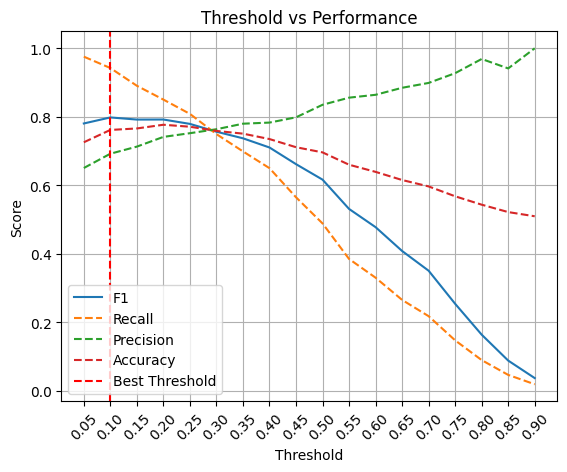

In [26]:
thresholds = [i / 100 for i in range(5, 95, 5)]  
results = []

for t in thresholds:
    preds = (df["toxicity_score"].apply(lambda x: is_toxic(x, threshold=t))).astype(int)
    precision = precision_score(df["label"], preds)
    recall = recall_score(df["label"], preds)
    f1 = f1_score(df["label"], preds)
    acc = accuracy_score(df["label"], preds)
    results.append((t, precision, recall, f1, acc))

best_threshold = max(results, key=lambda x: x[3])  # F1 score
print(f"Best threshold: {best_threshold[0]}")

# Convert to DataFrame for better display
threshold_df = pd.DataFrame(results, columns=["Threshold", "Precision", "Recall", "F1", "Accuracy"])

plt.plot(threshold_df["Threshold"], threshold_df["F1"], label="F1")
plt.plot(threshold_df["Threshold"], threshold_df["Recall"], label="Recall", linestyle='--')
plt.plot(threshold_df["Threshold"], threshold_df["Precision"], label="Precision", linestyle='--')
plt.plot(threshold_df["Threshold"], threshold_df["Accuracy"], label="Accuracy", linestyle='--')
plt.axvline(x=best_threshold[0], color='r', linestyle='--', label='Best Threshold')
plt.xticks(threshold_df["Threshold"], rotation=45)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Performance")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
y_pred = (df["toxicity_score"].apply(lambda x: is_toxic(x, threshold=best_threshold[0]))).astype(float)

# Rapport de classification
report = classification_report(y_true, y_pred, digits=3, output_dict=True)
table = Table(title="Classification Report", show_lines=True)
table.add_column("Classe", style="cyan", justify="center")
table.add_column("Precision", justify="center")
table.add_column("Recall", justify="center")
table.add_column("F1-score", justify="center")
table.add_column("Support", justify="center")

for label, metrics in report.items():
    if label in ["accuracy", "macro avg", "weighted avg"]:
        continue
    table.add_row(
        str(label),
        f"{metrics['precision']:.3f}",
        f"{metrics['recall']:.3f}",
        f"{metrics['f1-score']:.3f}",
        f"{int(metrics['support'])}"
    )
# Ajout de l'accuracy
table.add_row(
    "[bold yellow]Accuracy[/bold yellow]",
    "-",
    "-",
    f"{report['accuracy']:.3f}",
    "-"
)
console.print(table)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
cm_table = Table(title="Matrice de Confusion", show_lines=True)
cm_table.add_column(" ", style="bold")
cm_table.add_column("Prédit 0", justify="center")
cm_table.add_column("Prédit 1", justify="center")
cm_table.add_row("Réel 0", str(cm[0, 0]), str(cm[0, 1]))
cm_table.add_row("Réel 1", str(cm[1, 0]), str(cm[1, 1]))
console.print(cm_table)

# ROC AUC
try:
    auc = roc_auc_score(y_true, y_pred)
    console.print(Panel(f"[bold green]ROC AUC Score : {auc:.3f}[/bold green]", title="ROC AUC"))
except:
    console.print(Panel("[bold red]Impossible de calculer le ROC AUC.[/bold red]", title="ROC AUC"))

                Classification Report                 
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃  Classe  ┃ Precision ┃ Recall ┃ F1-score ┃ Support ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│    0     │   0.910   │ 0.581  │  0.709   │   694   │
├──────────┼───────────┼────────┼──────────┼─────────┤
│    1     │   0.692   │ 0.942  │  0.798   │   694   │
├──────────┼───────────┼────────┼──────────┼─────────┤
│ Accuracy │     -     │   -    │  0.762   │    -    │
└──────────┴───────────┴────────┴──────────┴─────────┘

      Matrice de Confusion      
┏━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃        ┃ Prédit 0 ┃ Prédit 1 ┃
┡━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ Réel 0 │   403    │   291    │
├────────┼──────────┼──────────┤
│ Réel 1 │    40    │   654    │
└────────┴──────────┴──────────┘

╭──────────────────────────────────────────────────── ROC AUC ────────────────────────────────────────────────────╮
│ ROC AUC Score : 0.762                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## Save the predictions

In [28]:
df["predictions"] = df['is_toxic'].astype(int)

In [29]:
df

,msg_id,content,label,toxicity_score,is_toxic,prediction,predictions
0,anon_msg_468ffd36870c,AYAAAAAAAAAAAA LES CRACKHEAD ANTI MIGRANT BORD...,1,"{'TOXICITY': 0.6426206, 'PROFANITY': 0.8255558...",True,1,1
1,anon_msg_c30ce8c67bac,Bordel le gars chantait 'FN souffrance' alors ...,1,"{'THREAT': 0.13127698, 'INSULT': 0.5678696, 'S...",True,1,1
2,anon_msg_a7be822bc051,Je vois que ça ddb en masse\nComme en dictatur...,1,"{'TOXICITY': 0.37751234, 'THREAT': 0.011430934...",False,0,0
3,anon_msg_8a2c7da3ff85,vous tenez là ? persoent c'est chaud depuis hi...,1,"{'THREAT': 0.050744623, 'INSULT': 0.40189892, ...",True,1,1
4,anon_msg_b20f2e8b51ed,Le racisme est devenu le crime ultime en Occid...,0,"{'INSULT': 0.3388922, 'PROFANITY': 0.04892669,...",False,0,0
...,...,...,...,...,...,...,...
1383,anon_msg_a3bb41085bd2,que j’entende plus un média dire le danger c’e...,0,"{'PROFANITY': 0.013131939, 'TOXICITY': 0.14776...",False,0,0
1384,anon_msg_835f5f8a3e25,il raconte absolument n'importe quoi non stop,0,"{'THREAT': 0.006155535, 'SEVERE_TOXICITY': 0.0...",False,0,0
1385,anon_msg_5de411f54a1b,mais qu'est ce qu'il raconte saint nikos,0,"{'THREAT': 0.0053957803, 'PROFANITY': 0.016206...",False,0,0
1386,anon_msg_48b9b19e3c3b,Oui el famoso 200 bordel\n:rire:\nLE QI bordel...,0,"{'SEVERE_TOXICITY': 0.023076924, 'INSULT': 0.2...",False,0,0


In [30]:
df.to_csv(output_path, index=False)